In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir(globals()['_dh'][0])
os.chdir('..')
# print(os.path.abspath(os.curdir))

import pickle
import numpy as np
import matplotlib.pyplot as plt

import rfcutils # this corresponds to utility functions provided for the challenge
get_sinr = lambda s, i: 10*np.log10(np.mean(np.abs(s)**2)/np.mean(np.abs(i)**2))

---

### 1. Loading all the training set frames from the dataset

In [2]:
sig_type = "EMISignal1"
# sig_type = "CommSignal2"
# sig_type = "CommSignal3"

num_train_frame = {"EMISignal1": 530, "CommSignal2": 100, "CommSignal3": 139}
# num_all_frame = {"EMISignal1": 580, "CommSignal2": 150, "CommSignal3": 189}
sig_dataset = []
for ii in range(num_train_frame[sig_type]):
    data,meta = rfcutils.load_dataset_sample(ii, "train_frame", sig_type)
    sig_dataset.append(data)
sig_dataset = np.array(sig_dataset)

In [3]:
print(sig_dataset.shape)

(530, 230000)


### 2. Creating more mixture examples

In [4]:
sig_mixture, sig1, sig2 = rfcutils.create_sep_mixture("EMISignal1", target_sinr_db=-5, dataset_type="train")
assert np.allclose(sig_mixture, sig1 + sig2)
print(get_sinr(sig1, sig2))

-5.0


In [5]:
sig_mixture, sig1, sig2, msg_bits = rfcutils.create_demod_mixture("CommSignal2", target_sinr_db=-5, dataset_type="train")
assert np.allclose(sig_mixture, sig1 + sig2)
assert np.allclose(rfcutils.matched_filter_demod(sig1), msg_bits)
print(get_sinr(sig1, sig2))

-4.999999701976776


### 3. Loading an example of a mixture

In [6]:
dataset_type = "sep_val"
interference_sig_type = "EMISignal1"
idx = 401

sig_mixture,meta = rfcutils.load_dataset_sample(idx, dataset_type, interference_sig_type)
sig1,meta1,sig2,meta2 = rfcutils.load_dataset_sample_components(idx, dataset_type, interference_sig_type)

assert np.allclose(sig_mixture, sig1 + sig2)
print(get_sinr(sig1, sig2))

-3.0000001192092896


In [7]:
dataset_type = "demod_val"
interference_sig_type = "CommSignal2"
idx = 401

sig_mixture,meta = rfcutils.load_dataset_sample(idx, dataset_type, interference_sig_type)
sig1,meta1,sig2,meta2 = rfcutils.load_dataset_sample_components(idx, dataset_type, interference_sig_type)
sig1_copy,meta1_copy,msg_bits,ground_truth_info = rfcutils.load_dataset_sample_demod_groundtruth(idx, dataset_type, interference_sig_type)

assert np.allclose(sig_mixture, sig1 + sig2)
assert np.allclose(sig1_copy, sig1)
assert np.allclose(rfcutils.matched_filter_demod(sig1), msg_bits)
print(get_sinr(sig1, sig2))

-2.9999998211860657


### 4. Suggested Routine for Evaluation

In [8]:
def user_def_sep_fn(sig_mixture):
    # perform separation here
    coeff = np.sqrt(1/(np.mean(np.abs(sig_mixture)**2)))
    sig1_est = coeff*sig_mixture
    sig2_est = sig_mixture - sig1_est
    
    return sig1_est, sig2_est

In [9]:
interference_sig_type = "EMISignal1"
# interference_sig_type = "CommSignal3"

dataset_type = "sep_val"
all_mse, all_default_mse, all_sinr = [], [], []

all_test_idx = np.arange(1100)
for idx in all_test_idx:
    sig_mixture,meta = rfcutils.load_dataset_sample(idx, dataset_type, interference_sig_type)
    
    # Separation
    sig1_est, sig2_est = user_def_sep_fn(sig_mixture)
    
    # Evaluation
    sig1,meta1,sig2,meta2 = rfcutils.load_dataset_sample_components(idx, dataset_type, interference_sig_type)
    sinr = get_sinr(sig1, sig2)
    all_sinr.append(sinr)
    mse_ref = np.mean(np.abs(sig_mixture-sig1)**2)
    all_default_mse.append(mse_ref)
        
    mse = mse_ref = np.mean(np.abs(sig1_est-sig1)**2)
    all_mse.append(mse)

#     print(f"#{idx} -- SINR {sinr:.3f}dB: MSE:{mse}")

In [10]:
baseline_mse = pickle.load(open(os.path.join('example','baseline',f'{dataset_type}_mse.pickle'), 'rb'))
baseline_mse[interference_sig_type].keys()

dict_keys(['LMMSE', 'No Separation'])

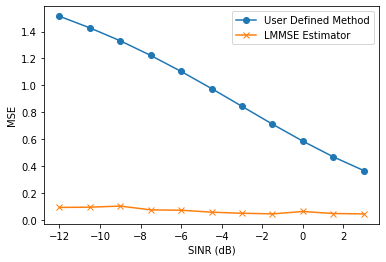

In [11]:
sinr_axis = np.array(all_sinr).reshape(-1,100).mean(axis=1)
mean_mse = np.array(all_mse).reshape(-1,100).mean(axis=1)

plt.plot(sinr_axis, mean_mse, 'o-')
plt.plot(sinr_axis, baseline_mse[interference_sig_type]["LMMSE"]["mean"], 'x-')
plt.xlabel('SINR (dB)')
plt.ylabel('MSE')
plt.legend(['User Defined Method','LMMSE Estimator'], loc="upper right")

In [12]:
def user_def_demod_fn(sig_mixture):
    # perform demodulation with interference mitigation here
    bit_est = rfcutils.matched_filter_demod(sig_mixture)
    
    return bit_est

In [13]:
# interference_sig_type = "EMISignal1"
interference_sig_type = "CommSignal2"
# interference_sig_type = "CommSignal3"

dataset_type = "demod_val"
all_ber, all_default_ber, all_sinr = [], [], []

all_test_idx = np.arange(1100)
for idx in all_test_idx:
    sig_mixture,meta = rfcutils.load_dataset_sample(idx, dataset_type, interference_sig_type)
    
    # Demodulation
    bit_est = user_def_demod_fn(sig_mixture)
    
    # Evaluation
    sig1,meta1,sig2,meta2 = rfcutils.load_dataset_sample_components(idx, dataset_type, interference_sig_type)
    sinr = get_sinr(sig1, sig2)
    all_sinr.append(sinr)
    ber_ref = rfcutils.demod_check_ber(rfcutils.matched_filter_demod(sig_mixture), idx, dataset_type, interference_sig_type)
    all_default_ber.append(ber_ref)
    
    ber = rfcutils.demod_check_ber(bit_est, idx, dataset_type, interference_sig_type)
    all_ber.append(ber)
    
#     print(f"#{idx} -- SINR {sinr:.3f}dB: BER:{ber}")

In [14]:
baseline_ber = pickle.load(open(os.path.join('example','baseline',f'{dataset_type}_ber.pickle'), 'rb'))
    
baseline_ber[interference_sig_type].keys()

dict_keys(['Matched Filtering', 'LMMSE+Matched Filtering', 'Bit Regression', 'RNN+Matched Filtering', 'Align+LMMSE+Matched Filtering'])

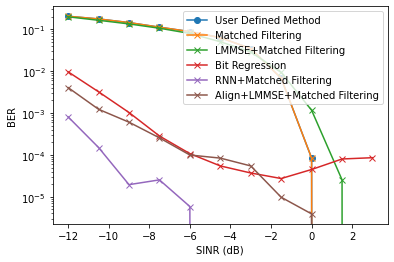

In [15]:
sinr_axis = np.array(all_sinr).reshape(-1,100).mean(axis=1)
mean_ber = np.array(all_ber).reshape(-1,100).mean(axis=1)

plt.plot(sinr_axis, mean_ber, 'o-')
for method_str in baseline_ber[interference_sig_type].keys():
    plt.semilogy(sinr_axis, baseline_ber[interference_sig_type][method_str]["mean"], 'x-')
plt.xlabel('SINR (dB)')
plt.ylabel('BER')
plt.legend(['User Defined Method']+list(baseline_ber[interference_sig_type].keys()), loc="upper right")

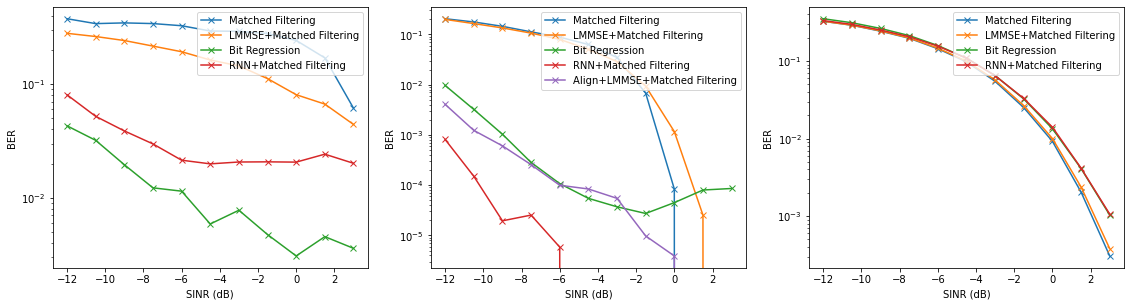

In [16]:
sinr_axis = np.arange(3,-13.5,-1.5)

plt.figure(figsize=(6.4*3,4.8))
for i,interference_sig_type in enumerate(['EMISignal1', 'CommSignal2', 'CommSignal3']):
    plt.subplot(1,3,i+1)
    for method_str in baseline_ber[interference_sig_type].keys():
        plt.semilogy(sinr_axis, baseline_ber[interference_sig_type][method_str]["mean"], 'x-')
    plt.xlabel('SINR (dB)')
    plt.ylabel('BER')
    plt.legend(list(baseline_ber[interference_sig_type].keys()), loc="upper right")